<a href="https://colab.research.google.com/github/HarshalRaut16/deep_learning_evaluation/blob/main/Task_2_Plastic_Bottles_or_Metal_Bottles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Mar 22 10:05:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

In [ ]:
#Unzip the downloaded file
zip_ref = zipfile.ZipFile("plastic_and_metal_bottles.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
!ls

drive  plastic_and_metal_bottles  plastic_and_metal_bottles.zip  sample_data


In [ ]:
!ls plastic_and_metal_bottles/Train_data

'Metal Bottle'	'Plastic Bottle'


In [ ]:
import os

# Walk through plastic_and_metal_bottles directory and list number of files
for dirpath, dirnames, filenames in os.walk("plastic_and_metal_bottles"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'plastic_and_metal_bottles'.
There are 2 directories and 0 images in 'plastic_and_metal_bottles/Train_data'.
There are 0 directories and 420 images in 'plastic_and_metal_bottles/Train_data/Plastic Bottle'.
There are 0 directories and 420 images in 'plastic_and_metal_bottles/Train_data/Metal Bottle'.
There are 2 directories and 0 images in 'plastic_and_metal_bottles/Test_data'.
There are 0 directories and 180 images in 'plastic_and_metal_bottles/Test_data/Plastic Bottle'.
There are 0 directories and 180 images in 'plastic_and_metal_bottles/Test_data/Metal Bottle'.


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (778, 531, 3)


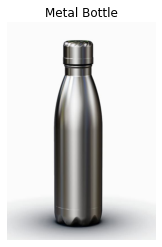

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="plastic_and_metal_bottles/Train_data/",
                        target_class="Metal Bottle")

In [ ]:
# View the img 
img

array([[[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [251, 251, 251],
        [251, 251, 251],
        [251, 251, 251]],

       [[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [251, 251, 251],
        [251, 251, 251],
        [251, 251, 251]],

       [[251, 251, 251],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [251, 251, 251],
        [251, 251, 251],
        [251, 251, 251]],

       ...,

       [[238, 240, 239],
        [238, 240, 239],
        [238, 240, 239],
        ...,
        [241, 243, 242],
        [241, 243, 242],
        [241, 243, 242]],

       [[240, 242, 241],
        [240, 242, 241],
        [240, 242, 241],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[240, 242, 241],
        [240, 242, 241],
        [240, 242, 241],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]]

In [ ]:
# View the image shape
img.shape # returns (width, height, colour channels)

(778, 531, 3)

In [ ]:
# Get all the pixel values between 0 & 1
img/255.

array([[[0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        ...,
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373]],

       [[0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        ...,
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373]],

       [[0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        ...,
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373],
        [0.98431373, 0.98431373, 0.98431373]],

       ...,

       [[0.93333333, 0.94117647, 0.9372549 ],
        [0.93333333, 0.94117647, 0.9372549 ],
        [0.93333333, 0

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 840 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/5
27/27 [==============================] - 32s 761ms/step - loss: 0.6972 - accuracy: 0.5333 - val_loss: 0.6557 - val_accuracy: 0.5694
Epoch 2/5
27/27 [==============================] - 21s 787ms/step - loss: 0.6223 - accuracy: 0.6702 - val_loss: 0.6135 - val_accuracy: 0.6389
Epoch 3/5
27/27 [==============================] - 19s 716ms/step - loss: 0.5441 - accuracy: 0.7417 - val_loss: 0.6081 - val_accuracy: 0.6778
Epoch 4/5
27/27 [==============================] - 21s 792ms/step - loss: 0.4586 - accuracy: 0.8036 - val_loss: 0.6171 - val_accuracy: 0.7028
Epoch 5/5
27/27 [==============================] - 19s 722ms/step - loss: 0.4271 - accuracy: 0.8071 - val_loss: 0.6228 - val_accuracy: 0.6917


In [ ]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
# model 2
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
27/27 [==============================] - 24s 861ms/step - loss: 1.0520 - accuracy: 0.5131 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
27/27 [==============================] - 19s 715ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
27/27 [==============================] - 22s 838ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
27/27 [==============================] - 19s 704ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
27/27 [==============================] - 22s 841ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [ ]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Increate neurons
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
27/27 [==============================] - 22s 759ms/step - loss: 10.4873 - accuracy: 0.5298 - val_loss: 0.8733 - val_accuracy: 0.6194
Epoch 2/5
27/27 [==============================] - 19s 694ms/step - loss: 3.6065 - accuracy: 0.5060 - val_loss: 3.1896 - val_accuracy: 0.5111
Epoch 3/5
27/27 [==============================] - 20s 758ms/step - loss: 1.5897 - accuracy: 0.5702 - val_loss: 0.9402 - val_accuracy: 0.5806
Epoch 4/5
27/27 [==============================] - 18s 695ms/step - loss: 1.4031 - accuracy: 0.5821 - val_loss: 2.8940 - val_accuracy: 0.5167
Epoch 5/5
27/27 [==============================] - 20s 756ms/step - loss: 1.2863 - accuracy: 0.6083 - val_loss: 0.7356 - val_accuracy: 0.6000


In [ ]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Image shape: (1500, 1500, 3)
Image shape: (560, 420, 3)


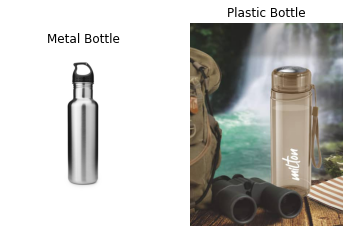

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
metal_bottle_img = view_random_image("plastic_and_metal_bottles/Train_data/", "Metal Bottle")
plt.subplot(1, 2, 2)
plastic_bottle_img = view_random_image("plastic_and_metal_bottles/Train_data/", "Plastic Bottle")

### 2. Preprocess the data (prepare it for a model)


In [ ]:
# Define training and test directory paths
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

In [ ]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 840 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [ ]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         [[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         [[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         ...,
 
         [[0.8196079 , 0.8196079 , 0.7725491 ],
          [0.82745

In [ ]:
# View the first batch of labels
labels

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(27, 12)

In [ ]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
27/27 [==============================] - 23s 784ms/step - loss: 5.9276 - accuracy: 0.5262 - val_loss: 0.6789 - val_accuracy: 0.5722
Epoch 2/5
27/27 [==============================] - 19s 735ms/step - loss: 0.6443 - accuracy: 0.6310 - val_loss: 0.6554 - val_accuracy: 0.6278
Epoch 3/5
27/27 [==============================] - 22s 834ms/step - loss: 0.6051 - accuracy: 0.6893 - val_loss: 0.6937 - val_accuracy: 0.6056
Epoch 4/5
27/27 [==============================] - 20s 736ms/step - loss: 0.5493 - accuracy: 0.7345 - val_loss: 0.6988 - val_accuracy: 0.5889
Epoch 5/5
27/27 [==============================] - 20s 773ms/step - loss: 0.4689 - accuracy: 0.7988 - val_loss: 0.6334 - val_accuracy: 0.6694


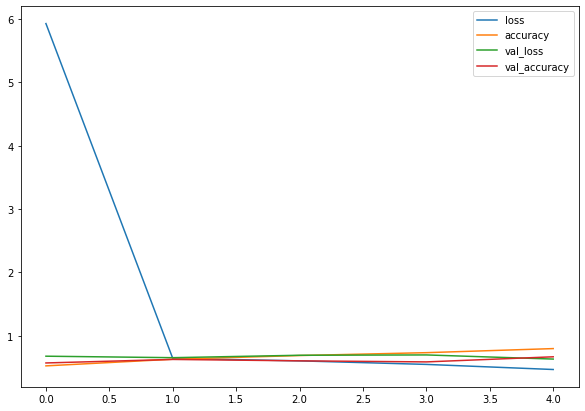

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
27/27 [==============================] - 23s 794ms/step - loss: 0.6833 - accuracy: 0.5595 - val_loss: 0.6798 - val_accuracy: 0.5389
Epoch 2/5
27/27 [==============================] - 19s 728ms/step - loss: 0.6263 - accuracy: 0.6726 - val_loss: 0.6283 - val_accuracy: 0.6472
Epoch 3/5
27/27 [==============================] - 20s 749ms/step - loss: 0.5585 - accuracy: 0.7226 - val_loss: 0.6207 - val_accuracy: 0.6722
Epoch 4/5
27/27 [==============================] - 19s 703ms/step - loss: 0.5154 - accuracy: 0.7488 - val_loss: 0.6613 - val_accuracy: 0.6667
Epoch 5/5
27/27 [==============================] - 22s 832ms/step - loss: 0.4963 - accuracy: 0.7679 - val_loss: 0.6248 - val_accuracy: 0.6694


In [ ]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

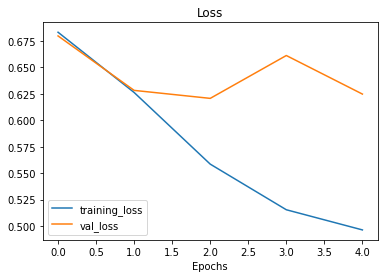

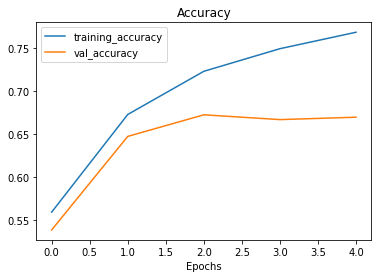

In [ ]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

# Data Augmentation 
- to increase size of data

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 840 images belonging to 2 classes.
Non-augmented training images:
Found 840 images belonging to 2 classes.
Unchanged test images:
Found 360 images belonging to 2 classes.


In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

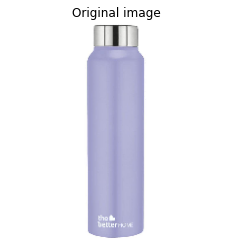

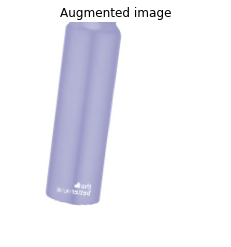

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
27/27 [==============================] - 30s 1s/step - loss: 0.7222 - accuracy: 0.4964 - val_loss: 0.6960 - val_accuracy: 0.4944
Epoch 2/5
27/27 [==============================] - 28s 1s/step - loss: 0.6960 - accuracy: 0.4833 - val_loss: 0.6866 - val_accuracy: 0.5778
Epoch 3/5
27/27 [==============================] - 28s 1s/step - loss: 0.6914 - accuracy: 0.5274 - val_loss: 0.6821 - val_accuracy: 0.6222
Epoch 4/5
27/27 [==============================] - 28s 1s/step - loss: 0.6905 - accuracy: 0.5488 - val_loss: 0.6655 - val_accuracy: 0.5944
Epoch 5/5
27/27 [==============================] - 31s 1s/step - loss: 0.6737 - accuracy: 0.5976 - val_loss: 0.6554 - val_accuracy: 0.5778


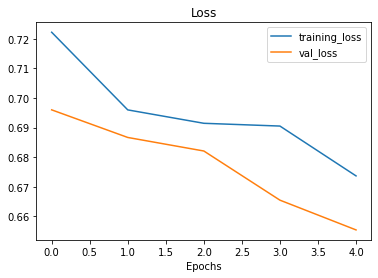

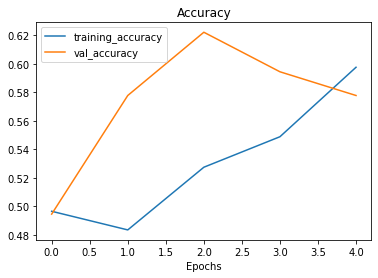

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

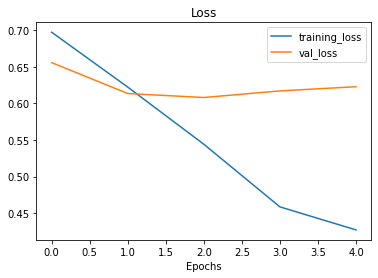

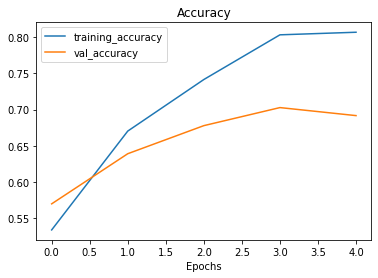

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 840 images belonging to 2 classes.


In [ ]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
27/27 [==============================] - 30s 1s/step - loss: 0.6970 - accuracy: 0.5155 - val_loss: 0.6829 - val_accuracy: 0.5917
Epoch 2/5
27/27 [==============================] - 31s 1s/step - loss: 0.6752 - accuracy: 0.5869 - val_loss: 0.6514 - val_accuracy: 0.6500
Epoch 3/5
27/27 [==============================] - 28s 1s/step - loss: 0.6541 - accuracy: 0.6060 - val_loss: 0.6223 - val_accuracy: 0.6611
Epoch 4/5
27/27 [==============================] - 28s 1s/step - loss: 0.6517 - accuracy: 0.6119 - val_loss: 0.6298 - val_accuracy: 0.6389
Epoch 5/5
27/27 [==============================] - 28s 1s/step - loss: 0.6276 - accuracy: 0.6393 - val_loss: 0.6206 - val_accuracy: 0.6361


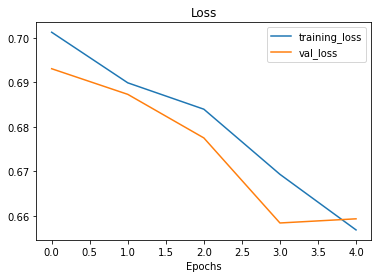

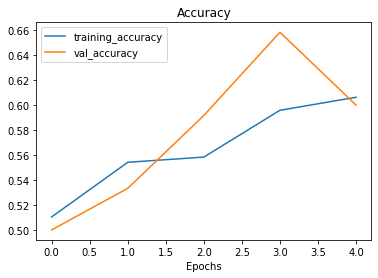

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

In [ ]:
# Create a CNN model 8
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
27/27 [==============================] - 30s 1s/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6896 - val_accuracy: 0.5806
Epoch 2/10
27/27 [==============================] - 28s 1s/step - loss: 0.6886 - accuracy: 0.5655 - val_loss: 0.6793 - val_accuracy: 0.6306
Epoch 3/10
27/27 [==============================] - 28s 1s/step - loss: 0.6748 - accuracy: 0.5940 - val_loss: 0.6526 - val_accuracy: 0.6361
Epoch 4/10
27/27 [==============================] - 28s 1s/step - loss: 0.6631 - accuracy: 0.6083 - val_loss: 0.6445 - val_accuracy: 0.6639
Epoch 5/10
27/27 [==============================] - 28s 1s/step - loss: 0.6695 - accuracy: 0.5726 - val_loss: 0.6419 - val_accuracy: 0.6361
Epoch 6/10
27/27 [==============================] - 28s 1s/step - loss: 0.6460 - accuracy: 0.6393 - val_loss: 0.6252 - val_accuracy: 0.6833
Epoch 7/10
27/27 [==============================] - 28s 1s/step - loss: 0.6434 - accuracy: 0.6393 - val_loss: 0.6093 - val_accuracy: 0.7083
Epoch 8/10
27/27 [==

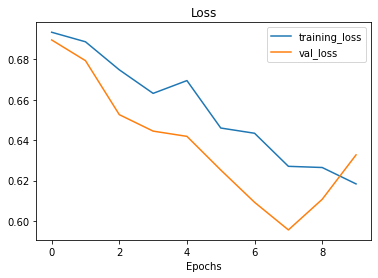

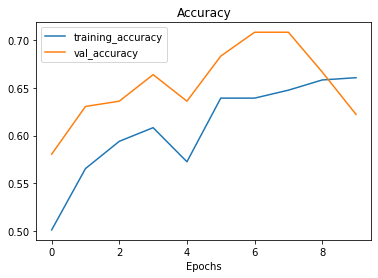

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_8)

### Try Pre-trained model(transfer learning) beacause we still get 62% accuracy on our model 8

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup the train and test directories
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_tf = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data_tf = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 840 images belonging to 2 classes.
Testing images:
Found 360 images belonging to 2 classes.


In [ ]:
train_data_tf.image_shape, test_data_tf.image_shape

((224, 224, 3), (224, 224, 3))

## Setting up callbacks

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# this url is for download pretrained model from tensorflow_hub

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Function to make model
def create_model(model_url, num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes= 1)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_tf,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_tf),
                                  validation_data=test_data_tf,
                                  validation_steps=len(test_data_tf),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230322-120032
Epoch 1/5
27/27 [==============================] - 22s 784ms/step - loss: 0.3461 - accuracy: 0.8679 - val_loss: 0.4236 - val_accuracy: 0.8083
Epoch 2/5
27/27 [==============================] - 22s 832ms/step - loss: 0.2925 - accuracy: 0.8917 - val_loss: 0.4097 - val_accuracy: 0.8222
Epoch 3/5
27/27 [==============================] - 20s 737ms/step - loss: 0.2596 - accuracy: 0.9036 - val_loss: 0.4012 - val_accuracy: 0.8306
Epoch 4/5
27/27 [==============================] - 21s 797ms/step - loss: 0.2381 - accuracy: 0.9155 - val_loss: 0.3945 - val_accuracy: 0.8389
Epoch 5/5
27/27 [==============================] - 22s 798ms/step - loss: 0.2202 - accuracy: 0.9286 - val_loss: 0.4006 - val_accuracy: 0.8389


In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

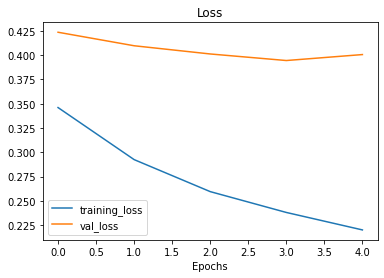

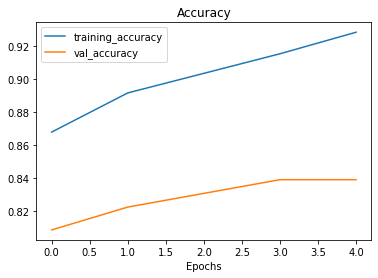

In [ ]:
plot_loss_curves(resnet_history)

## Create efficientnet_model

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=1)

# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0012),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_tf,
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_tf),
                                              validation_data=test_data_tf,
                                              validation_steps=len(test_data_tf),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230322-130134
Epoch 1/5
27/27 [==============================] - 33s 874ms/step - loss: 0.5287 - accuracy: 0.7250 - val_loss: 0.4474 - val_accuracy: 0.8306
Epoch 2/5
27/27 [==============================] - 20s 728ms/step - loss: 0.3578 - accuracy: 0.8750 - val_loss: 0.4011 - val_accuracy: 0.8222
Epoch 3/5
27/27 [==============================] - 21s 797ms/step - loss: 0.2939 - accuracy: 0.9071 - val_loss: 0.3721 - val_accuracy: 0.8611
Epoch 4/5
27/27 [==============================] - 20s 740ms/step - loss: 0.2592 - accuracy: 0.9202 - val_loss: 0.3644 - val_accuracy: 0.8583
Epoch 5/5
27/27 [==============================] - 21s 788ms/step - loss: 0.2364 - accuracy: 0.9286 - val_loss: 0.3652 - val_accuracy: 0.8528


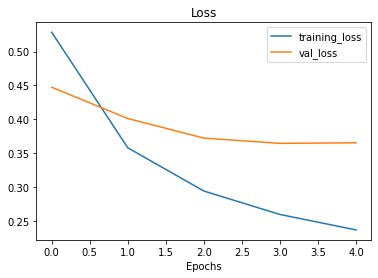

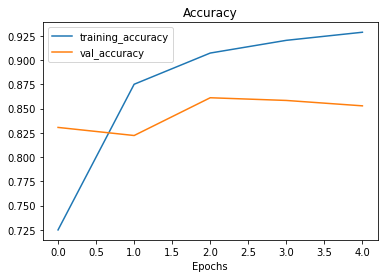

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);